<center>
    
## Aprendizaje No Supervisado DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2019 dataset
 
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

In [2]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

In [3]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [4]:
df=pd.read_csv("data.csv")

**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall")**

**y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [5]:
n=10000
df_n=df.loc[:n] #los primeros n
df_n=df_n[(df_n['Overall']>70)] # mejores jugadores

skills_ratings = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
                  'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
                  'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
                  'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
                  'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                  'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
                  'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']

print(len(skills_ratings), 'variables numéricas: skills/habilidades')

df_skills=df_n[skills_ratings]

34 variables numéricas: skills/habilidades


# 3.-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo. 


In [6]:
# Número de clusters buscado
n_clust = 5

km = KMeans(n_clusters=n_clust)
km.fit(df_skills) #utiliza todas las habilidades: 34 dimensiones

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  11269857.57393805


**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

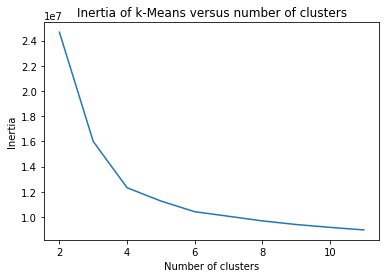

In [7]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

**Graficamos el resultado de agrupar a los jugadores usando kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [8]:
bool_crack=df_n["Overall"] > 85
bool_no_crack=df_n["Overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[9]
skill_2=skills_ratings[10]

In [15]:
kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [14]:
#En Colab:
fig.show(renderer="colab")

In [ ]:
#En Jupyter:
iplot(fig)
#plot(fig)

In [18]:
df_clusters=df_n.copy()
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  5 clusters, nosotros forzamos la cantidad


**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los clusters, usando las clases asignadas por kmeans** 
- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster
- Tabla de contingencia alguna categórica vs clusters
- Silohuette?


# 4.-Clustering-Mean-Shift 

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio/bandwith (de cobertura para cálculo de media). (Probar con varios)

In [9]:
ms = MeanShift(bandwidth=2, bin_seeding=True)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 3


Graficamos los resultados:

In [10]:
bool_crack=df_n["Overall"] > 85
bool_no_crack=df_n["Overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[5]
skill_2=skills_ratings[14]

In [27]:
data=[]
MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [28]:
#En Colab
fig.show(renderer="colab")

In [23]:
df_clusters['MeanShift'] = ms.labels_ #clusters2
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  5 clusters, nosotros lo forzamos
Mean shift encontró  3 clusters, según los hiperparámetros elegidos


**EVALUACIÓN**

**EJERCICIO EN GRUPO: Análisis exploratorio de los clusters, usando las clases asignadas por MeanShift** 

In [ ]:
#Cantidad de observaciones por Cluster
#Análisis descriptivo separando por Cluster
#Tabla de contingencia alguna categórica vs clusters
#Silohuette?


**Pregunta: normalizamos/estandarizamos la base?**

**Ahora vemos que agrupamientos se pueden hacer excluyendo los arqueros**

# 5.-Clustering-con-Kmeans-sin-arqueros

In [11]:
n=10000
df_n=df.loc[:n]
df_n=df_n[(df_n["Position"]!='GK')&(df_n['Overall']>69)]

skills_ratings = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']

df_skills=df_n[skills_ratings]


In [12]:
# Número de clusters buscado
n_clust = 5

km = KMeans(n_clusters=n_clust)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_

In [13]:
#data=[]
bool_crack=df_n["Overall"] > 85
bool_no_crack=df_n["Overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[5]
skill_2=skills_ratings[15]

In [15]:
kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

In [16]:
#En Colab
fig.show(renderer="colab")

In [ ]:
#en Jupyter:
plot(fig)

# 6.-Clustering-Mean-Shift-sin-arqueros 

In [17]:
ms = MeanShift(bandwidth=2, bin_seeding=True)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_)

Numero de clusters encontrado por Mean Shift : 13


In [22]:
bool_crack=df_n["Overall"] > 85
bool_no_crack=df_n["Overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[9]
skill_2=skills_ratings[10]
print(skill_1,skill_2)

BallControl Acceleration


In [21]:
MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [23]:
#En Colab
fig.show(renderer="colab")

In [ ]:
#En Jupyter
iplot(fig)

In [ ]:
df_clusters=df_skills
df_clusters['kmeans'] = km.labels_ #clusters
df_clusters['MeanShift'] = ms.labels_ #clusters2

**Análisis exploratorio de las clases**